# Mathematical programming with Jupyter Notebooks
# Cutting plane algorithm

*Copyright 2016, Pedro Belin Castellucci & Franklina Maria Bragion de Toledo, All rights reserved.*

*This Notebook is licenced under GLPv3 (https://opensource.org/licenses/GPL-3.0).*

This Notebook talks about cutting plane algorithms and Chvàtal-Gomory cuts and is based on chapter eigth of the book Integer Programming (Wolsey, 1998).

A cutting plane algorithm is an algorithm that makes use of the valid inequalities we have discussed to automatically reformulate an integer problem in order to get closer the convex hull of its feasible region. However, there might be a huge number of valid inequalities to be added in a formulation of an integer programming problem. Adding all these inequalities *a priori* may make even the linear relaxation of the problem to be computationally intractable. The idea of cutting plane algorithms is adding valid inequalities as they are needed, namely, when they will eliminate non-integer optimal solutions for the linear relaxation of a problem.

Let $\mathbb{F}$ be a set of valid inequalities for a integer problem $IP$:

$Min \ c(x)$

s.t. $x \in X$,

with  $X = P \cap \mathbb{Z}^n$.

A cutting plane algorithm can be briefly described as follows:

1. Solve the linear relaxation $z^R = Min \{c(x): x \in P\}$. Let $x^t$ be an optimal solution for it;

    2. If $x^t \in \mathbb{Z}^n$, stop. $x^t$ is an optimal solution to IP.
    
    3. Otherwise, 
    
        5. if $x^t$ violates inequality $j \in \mathbb{F}$: add inequality $j$ to the linear relaxation ($P$) and go back to step 1.
        
        6. othewise, stop. 

If the algorithms stops without an integer solution, we have a better formulation with all the added valid inequalities.

Now, we will implement an example with PuLP. Consider the following IP problem:

$Max \ 4x_1 - x_2$

s.t. 

$7x_1 - 2x_2 + x_3 = 14$,

$x_2 + x_4 = 3$,

$2x_1 - 2x_2 + x_5 = 3$,

$x_1, x_2, x_3, x_4, x_5 \in \mathbb{Z}_+$,


Also, let $x_3 + 2x_4 \geq 6$ and $x_5 \geq 1$ be two valid inequalities for the problem. We will solve the linear relaxation of the problem -- without the valid inequalities.

In [1]:
import pulp

model = pulp.LpProblem('Cutting plane example', pulp.LpMaximize)

# Note that we are defining the variables as continuous, NOT integer!
x1 = pulp.LpVariable('x1', lowBound=0, cat='Continuous')
x2 = pulp.LpVariable('x2', lowBound=0, cat='Continuous')
x3 = pulp.LpVariable('x3', lowBound=0, cat='Continuous')
x4 = pulp.LpVariable('x4', lowBound=0, cat='Continuous')
x5 = pulp.LpVariable('x5', lowBound=0, cat='Continuous')

# The objective function:
model += 4*x1 - x2

model += 7*x1 - 2*x2 + x3 == 14
model += x2 + x4 == 3
model += 2*x1 - 2*x2 + x5 == 3

model.solve()

for v in model.variables():
    print '%s = %.2f;' % (v, v.value())
    
print ('The optimal solution is %.2f' % model.objective.value())

x1 = 2.86;
x2 = 3.00;
x3 = 0.00;
x4 = 0.00;
x5 = 3.29;
The optimal solution is 8.43


We can see that PuLP found the optimal solution $(x_1, x_2, x_3, x_4, x_5) = (2.86, 3, 0, 0, 3.29)$. In this solution there are two non-integer variables, $x_1$ and $x_2$. Also, we can see that this solution violates the inequality $x_3 + 2x_4 \geq 6$, so let us add it into the model.

In [2]:
# Adding the valid inequality:
model += x3 + 2*x4 >= 6

# Re-solving the problem:
model.solve()

for v in model.variables():
    print '%s = %.2f;' % (v, v.value())
    
print ('The optimal solution is %.2f' % model.objective.value())

x1 = 2.00;
x2 = 0.50;
x3 = 1.00;
x4 = 2.50;
x5 = 0.00;
The optimal solution is 7.50


Now, we have the solution $(x_1, x_2, x_3, x_4, x_5) = (2, 0.5, 1, 2.5, 0)$. This solution is still not integer. Let us try adding another violeted valid inequality, $x \geq 1$.

In [3]:
# Adding the valid inequality:
model += x5 >= 1

# Re-solving the model:
model.solve()

for v in model.variables():
    print '%s = %.2f' % (v, v.value())
    
print ('The optimal solution is %.2f' % model.objective.value())

x1 = 2.00
x2 = 1.00
x3 = 2.00
x4 = 2.00
x5 = 1.00
The optimal solution is 7.00


With both valid inequalities we could obtain an integer solution to our relaxation, which is also a feasible solution to the original problem. Thus, since we have a lower bound, $\underline{z}$, and an upper bound $\bar{z}$ such that $\underline{z} = \bar{z}$, we have found an optimal solution to the original integer problem.

Note that, in our example, we already had a family of valid inequalities. A natural question arises: *how to obtain a __good__ family of valid inequalities?* There are many answers to this question ranging from simple and general to sofisticated and problem-based rules. We will briefly discuss what is call __Gomory's fractional cutting plane algorithm__. 


## Gomory's fractional cutting plane algorithm

It is a cutting plane algorithm which allows us to obtain valid inequalities for an integer problem based on an optimal solution of its linear relaxation. 

A solution of a linear optimization problem $z = \{Min\ c(x): Ax = b\}$ can be written as $x = x_B + x_N$ such that $Ax = b \implies Bx_B + Nx_N = b$, with $Bx_B = b$ and $Nx_N = 0$. The matrix $B$ is called __basis__. If $x$ corresponds to an optimal solution, then $B$ is called an __optimal basis__. Gomory's cutting plane algorithm uses an optimal basis to build a valid inequality that eliminates the current optimal solution of the linear relaxation.

If the optimal solution to the linear relaxation $x$ is not integer, we must have $x_i \notin \mathbb{Z}$ for some $i$. Thus, we use the $i$-th row of matrix $A$ to generate the following valid inequality:

$$x_i + \sum_{j \in N} \left \lfloor a_{ij} \right \rfloor x_j \leq \left \lfloor b_i \right \rfloor.$$

Abusing notation, $j \in N$ means we are summing over all non-basic variables.

We will see how this works in an example. Consider the following problem:

$Min\ c^Tx$,

s. t. $\bar{A}\bar{x} \leq b$,

$\bar{x} \in \mathbb{Z}_+$.

Adding slack variables we have:

$Min\ c^Tx$,

s. t. $Ax = b$,

$x \in \mathbb{Z}_+$.


Also, let us consider the following data for $A$, $b$ and $c$.

In [6]:
import pulp
import numpy as np

A = np.matrix(
    '1 4 1 0;'
    '1 1 0 1'
    )

b = np.matrix(
    '8;'
    '4'
    )

c = np.matrix(
    '3;'
    '10')
    

Plotting the feasible region for the linear relaxation of the problem...

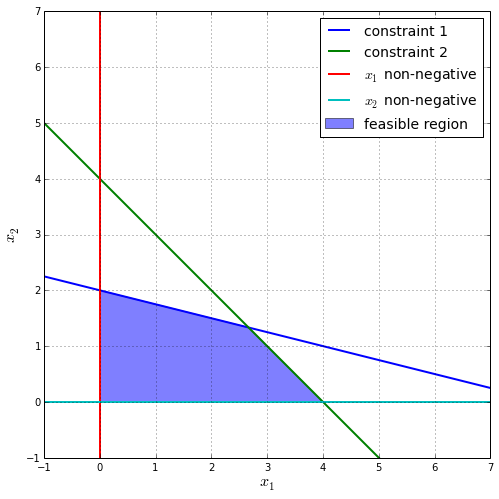

In [7]:
#matplotbib for drawing
%matplotlib inline

from matplotlib import pyplot as plt
from matplotlib.path import Path
from matplotlib.patches import PathPatch
from IPython.display import display

# create the plot object
fig, ax = plt.subplots(figsize=(8, 8))
s = np.linspace(-1, 7)

# add the first constraint
ax.plot(s, (b[0,0]-A[0,0]*s)/A[0,1], lw=2, label='constraint 1')

# add the second constraint
ax.plot(s, (b[1,0] - A[1,0]*s)/A[1,1], lw=2, label='constraint 2')

# add the non-negativity constraints
ax.plot(np.zeros_like(s), s, lw=2, label='$x_1$ non-negative')
ax.plot(s, np.zeros_like(s), lw=2, label='$x_2$ non-negative')

# highlight the feasible region
path = Path([
    (0., 0.),
    (0., 2),
    (8/3.0, 4/3.0),
    (4, 0),
    (0., 0.),
    (0., 0.),
])

patch = PathPatch(path, label='feasible region', alpha=0.5)
ax.add_patch(patch)

# labels and stuff
plt.xlabel('$x_1$', fontsize=16)
plt.ylabel('$x_2$', fontsize=16)
plt.xlim(-1, 7)
plt.ylim(-1, 7)
plt.legend(fontsize=14)
plt.grid()
plt.show()

Using PuLP to solve the linear relaxation we get:

In [8]:
model = pulp.LpProblem('Cutting plane example 2', pulp.LpMaximize)

x1 = pulp.LpVariable('x1', lowBound=0, cat='Continuous')
x2 = pulp.LpVariable('x2', lowBound=0, cat='Continuous')
x3 = pulp.LpVariable('x3', lowBound=0, cat='Continuous')
x4 = pulp.LpVariable('x4', lowBound=0, cat='Continuous')

# x5 = pulp.LpVariable('x5', lowBound=0, cat='Continuous')

model += c[0, 0]*x1 + c[1, 0]*x2

model += A[0, 0]*x1 + A[0, 1]*x2 + A[0, 2]*x3 + A[0, 3]*x4 == b[0, 0]
model += A[1, 0]*x1 + A[1, 1]*x2 + A[1, 2]*x3 + A[1, 3]*x4 == b[1, 0]
# model += A[2, 0]*x1 + A[2, 1]*x2 + A[2, 2]*x3 + A[2, 3]*x4 + A[2, 4]*x5 == b[2, 0]

model.solve()

originalX1, originalX2 = None, None
for v in model.variables():
    print '%s = %.2f;' % (v, v.value())
    
    if v == x1:
        originalX1 = x1.value()
    if v == x2:
        originalX2 = x2.value()

print ('The value of the objective function is %.2f.' % (model.objective.value()))


x1 = 2.67;
x2 = 1.33;
x3 = 0.00;
x4 = 0.00;
The value of the objective function is 21.33.


Note that the optimal solution is not integer so we can try to generate a valid inequality to eliminate this solution. In order to use Gomory's cutting plane algorithm, we need to find the optimal basis for this solution.

In [11]:
varDict = {0: x1, 1: x2, 2:x3, 3:x4}
# varDict = {0: x1, 1: x2, 2:x3, 3:x4, 4:x5}

basicVarIdx = [0, 1]
nonBasicVarIdx = [i for i in range(A.shape[1]) if i not in basicVarIdx]

basicVarIdx = sorted(basicVarIdx)

basicMatrix = A[:, basicVarIdx[0]]
basicMatrix = np.concatenate((basicMatrix, A[:, basicVarIdx[1]]), axis=1)
# basicMatrix = np.concatenate((basicMatrix, A[:, basicVarIdx[2]]), axis=1)

nonBasicMatrix = A[:, nonBasicVarIdx[0]]
nonBasicMatrix = np.concatenate((nonBasicMatrix, A[: , nonBasicVarIdx[1]]), axis=1)

# What we actually want is the inverse
basicMatrix = basicMatrix**-1

print ('The optimal basis is:\n', basicMatrix)


('The optimal basis is:\n', matrix([[-0.33333333,  1.33333333],
        [ 0.33333333, -0.33333333]]))


Now we need to choose one variable that is not integer in order to generate the cut.

In [12]:
varIdx = 1  # We are choosing varible (x2, index 1)

Then, we generate the cut:

$$x_i + \sum_{j \in N} \left \lfloor a_{ij} \right \rfloor x_j \leq \left \lfloor b_i \right \rfloor.$$

In [13]:
# Getting the correspondent rows in the matrix:
CGx = (basicMatrix*nonBasicMatrix)[varIdx]
CGb = (basicMatrix*b)[varIdx]
       
# Floor operation for a_{ij} and b_i
CGx = np.floor(CGx)
CGb = np.floor(CGb)

# Building the left-hand side of our cut:       
cut = varDict[varIdx] + CGx[0, 0]*varDict[nonBasicVarIdx[0]] + CGx[0, 1]*varDict[nonBasicVarIdx[1]]

# Adding the cut into the model:
model += cut <= CGb[0, 0]

# Re-solving
print model.solve()

print ('The cut we have generated is: ')
print cut <= CGb[0, 0]
print
print ('Getting the new solution:')
for v in model.variables():
    print '%s = %.2f;' % (v, v.value())

print ('The value of the objective function is %.2f.' % model.objective.value())


1
The cut we have generated is: 
x2 - x4 <= 1.0

Getting the new solution:
x1 = 2.00;
x2 = 1.50;
x3 = 0.00;
x4 = 0.50;
The value of the objective function is 21.00.


Note that the value of the objective function is worse than before, that is because the first problem is a relaxation of the new problem. Also, there are still variables with non integer values, so we should iterate again. But, before we do that, let us analyse our solution a bit more.

The cut we generated is $x_2 - x_4 \leq 1$. In order to visualise it we can re-write it as: 

$x_1 - 2x_2 \leq 5$,

where we used $x_4 = 4 - x_1 - x_2$.

Now, we will plot the original feasible region with the cut.

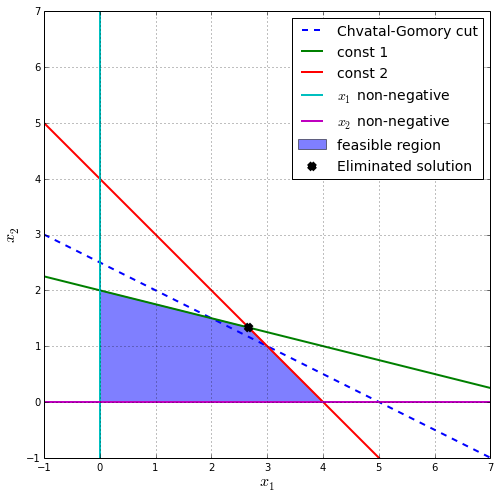

In [14]:
# create the plot object
fig, ax = plt.subplots(figsize=(8, 8))
s = np.linspace(-1, 7)

# add the cut we have generated
ax.plot(s, (5.0 - s)/2.0, '--', lw=2, label='Chvatal-Gomory cut')

# add first constraint
ax.plot(s, (b[0,0]-A[0,0]*s)/A[0,1], lw=2, label='const 1')

# add second constraint
ax.plot(s, (b[1,0] - A[1,0]*s)/A[1,1], lw=2, label='const 2')

# add non-negativity constraints
ax.plot(np.zeros_like(s), s, lw=2, label='$x_1$ non-negative')
ax.plot(s, np.zeros_like(s), lw=2, label='$x_2$ non-negative')

# highlight the feasible region
path = Path([
    (0., 0.),
    (0., 2),
    (8/3.0, 4/3.0),
    (4, 0),
    (0., 0.),
    (0., 0.),
])

patch = PathPatch(path, label='feasible region', alpha=0.5)
ax.add_patch(patch)

plt.scatter([originalX1], [originalX2],
            marker='x', color='black',
            s=40, linewidth=5,
            label='Eliminated solution',
            zorder=10)

# labels and stuff
plt.xlabel('$x_1$', fontsize=16)
plt.ylabel('$x_2$', fontsize=16)
plt.xlim(-1, 7)
plt.ylim(-1, 7)
plt.legend(fontsize=14, scatterpoints=1)
plt.grid()
plt.show()

Note that the cut eliminates the optimal solution we were getting in the linear relaxation of the problem. Also, since it is a valid inequality, it does not separate any other integer solution from the feasible region. 

Now, you can go back to the problem and iterate one more time to eliminate the current solution, since it is also non-integer.